### Unsupervised Searches For Parity Violation

This Notebook, acts as to demonstrate the the code base used for our paper to detect parity violation
The Notebook is split into the following sections:
- Data loading
- Creating Images
- Training the model

#### Data Loading
We begin by loading the boss data, and then we generate some random data that we know to be parity violating.

##### Boss Data:

In [1]:
from ml_pv.datagen.load_boss import prepare_boss_data

# Load the BOSS data for the CMASS North sample
boss_coords, boss_z, boss_w = prepare_boss_data(
        fits_file='data/galaxy_DR12v5_CMASS_North.fits',
        sample_size=700000,
        random_seed=42,
        z_min=0.43, # Add min and max redshfit cutoffs
        z_max=0.7,
    )

Sample size 618806 exceeds total entries 618806. Using all entries.


In [2]:
print(f"Coordinates shape: {boss_coords.shape}") # Check the number of coords after filtering

Coordinates shape: (568776,)


##### Helix Data

- Helices are handed objects in 3d
- By creating a datset where 'galaxies' contribute to larger 'helix structures' we are creating a dataset which can be made parity violating, by controlling the freqeuncy of each handedness
- It is important to note that the example shown here is purely a helix field (i.e. all galaxies exist as part of a helix)
    - This is not particularly realistic but is used to show that the model can successfully detect 3d parity violations
    - More realistic test cases are used in the paper

In [3]:
from ml_pv.datagen.boss_loader.helix_field import generate_helices, plot_helices_3d

# Create a non-parity violating set of helices
helices_even = generate_helices(parity_split=0.5)
print(f"Generated {len(helices_even)} even helices from the BOSS data.")
# Create a parity-violating set of helices
helices_odd = generate_helices(parity_split=0.7)
print(f"Generated {len(helices_odd)} odd helices from the BOSS data.")

Generated 200 even helices from the BOSS data.
Generated 200 odd helices from the BOSS data.


We now plot one of the helix fields to show the creation of chiral objects.\
Note that the plot using line smoothing to better show the helices, in reality each helix contain ~20 galaxies

In [4]:
# Plot the helices in 3D to visualise the helix field
plot_helices_3d(helices_even)

##### Creating Images

Now that we have loaded the galaxy data, we need to construct the images to use for the CNN

In [20]:
from ml_pv.datagen.image_gen.sampler import random_sampling_images
from ml_pv.datagen.image_gen.rendering import display_sample_dist

out_dir_boss = 'all_images/ipynb_demo_boss'
out_dir_helix = 'all_images/ipynb_demo_helices'

def run_image_generation(
    ra=boss_coords.ra.deg,
    dec=boss_coords.dec.deg,
    z=boss_z,
    w=boss_w,
    out_dir=out_dir_boss,
    num_train_samples = 96,
    num_test_samples = 24,
    square_size=0.5,
    img_size=64,
    bw_mode=False, 
    prefix='boss',
):
    """
    Generate images from the BOSS data using random sampling.
    
    :param coords: Coordinates of galaxies.
    :param z: Redshift values.
    :param w: Weights for the galaxies.
    :param cfg: Configuration object containing image generation parameters.
    :param out_dir: Output directory for the generated images.
    """
    # Generate the testing images first
    testing, _, avg_n_test = random_sampling_images(
        ra=ra,
        dec=dec,
        redshift=z,
        weights=w,
        num_samples=num_test_samples,
        square_size=square_size,
        img_size=img_size,
        bw_mode=bw_mode,
        output_dir=f"{out_dir}/test/test",
        prefix=f"{prefix}_test_",
    )

    print(
        f"Finished: generated {num_test_samples} testing images in {out_dir},\n avg {avg_n_test} points/image"
    )

    # Now generate the training images, ensuring they do not overlap with testing images
    training, _, avg_n_train = random_sampling_images(
        ra=ra,
        dec=dec,
        redshift=z,
        weights=w,
        num_samples=num_train_samples,
        square_size=square_size,
        img_size=img_size,
        bw_mode=bw_mode,
        output_dir=f"{out_dir}/train/train",
        prefix=f"{prefix}_train_",
        preexisting_squares=testing, # Stop training samples from overlapping with testing samples
    )
    print(
        f"Finished: generated {num_train_samples} training images in {out_dir},\n avg {avg_n_train} points/image"
    )

    # Create a visualization of the sample distribution
    viz_out = f'plots/sample_dist_{prefix}_ipynb.png'
    display_sample_dist(
        ra=ra,
        dec=ra,
        train_squares=training,
        test_squares=testing,
        output_path=viz_out,
    )
    print(f"Saved sample‐distribution plot to {viz_out}")


In [21]:
run_image_generation(boss_coords.ra.deg, boss_coords.dec.deg, boss_z, boss_w, out_dir_boss, prefix='boss')

helices_odd = helices_odd.reshape(-1, 3)
run_image_generation(ra=helices_odd[:,0], dec=helices_odd[:,1], z=helices_odd[:,2],
                    out_dir=out_dir_helix, square_size=0.5, prefix='helix')

Generating images:   0%|          | 0/24 [00:00<?, ?it/s]

Generating images: 100%|██████████| 24/24 [00:00<00:00, 36.77it/s]


Finished: generated 24 testing images in all_images/ipynb_demo_boss,
 avg 18.916666666666668 points/image


Generating images: 100%|██████████| 96/96 [00:02<00:00, 37.21it/s]


Finished: generated 96 training images in all_images/ipynb_demo_boss,
 avg 18.541666666666668 points/image
Saved sample‐distribution plot to plots/sample_dist_boss_ipynb.png


Generating images: 100%|██████████| 24/24 [00:00<00:00, 73.11it/s]


Finished: generated 24 testing images in all_images/ipynb_demo_helices,
 avg 34.458333333333336 points/image


Generating images: 100%|██████████| 96/96 [00:01<00:00, 61.55it/s]


Finished: generated 96 training images in all_images/ipynb_demo_helices,
 avg 38.885416666666664 points/image
Saved sample‐distribution plot to plots/sample_dist_helix_ipynb.png


Displaying random images from the BOSS dataset:



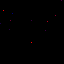
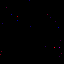
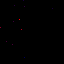
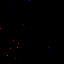
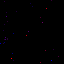

Displaying random images from the Helix dataset:



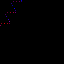
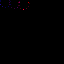
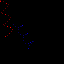
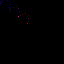
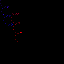

In [24]:
import os
import random
import base64
from IPython.display import display, HTML

boss_img_path = 'all_images/ipynb_demo_boss/train/train'
helix_img_path = 'all_images/ipynb_demo_helices/train/train'

def display_random_images_row(image_dir, num_images=5, scale=6):
    image_files = [f for f in os.listdir(image_dir) if f.endswith('.png')]
    selected_files = random.sample(image_files, min(num_images, len(image_files)))
    images = [os.path.join(image_dir, f) for f in selected_files]
    html = "<div style='display: flex; gap: 10px;'>"
    for img_path in images:
        with open(img_path, "rb") as f:
            data = base64.b64encode(f.read()).decode()
        html += (
            f"<img src='data:image/png;base64,{data}' width='{64*scale}' height='{64*scale}' "
            "style='image-rendering: pixelated; image-rendering: crisp-edges; border:1px solid #ccc;'/>"
        )
    html += "</div>"
    display(HTML(html))

print("Displaying random images from the BOSS dataset:")
display_random_images_row(boss_img_path, num_images=5, scale=6)
print("Displaying random images from the Helix dataset:")
display_random_images_row(helix_img_path, num_images=5, scale=6)

##### Training the model

Now we have created sets of images, we can train the model to detect parity violation.